# Regression Notebook

## Import libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import RFE
from numpy.polynomial.polynomial import polyfit
from pandas import Series
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARMA
from statsmodels.compat import lzip

## Load data

In [2]:
!pwd

/Users/flatironschool/Documents/mod_4_project


In [3]:
!ls

Non-technical.ipynb       __pycache__               images
README.md                 combine_data.csv          mod_4_proj_notebook.ipynb
TS                        helper_module.py          nt_notebook.ipynb


In [4]:
# https://www.kaggle.com/savvastj/nfl-combine-data

In [5]:
basic_df = combine_data = pd.read_csv('combine_data.csv')

In [6]:
basic_df.shape

(6218, 16)

## Get data ready

In [7]:
combine_data.Pick.fillna(0,inplace=True)
combine_data = combine_data[combine_data.Pick>0]
combine_data.set_index('Player',inplace=True)

In [8]:
combine_data.drop(['Pfr_ID','AV','Team','Round','Year'],axis=1,inplace=True)

In [9]:
combine_data.Forty.fillna(0,inplace=True)
combine_data = combine_data[combine_data.Forty>0]
combine_data.Vertical.fillna(0,inplace=True)
combine_data = combine_data[combine_data.Vertical>0]
combine_data.BenchReps.fillna(0,inplace=True)
combine_data = combine_data[combine_data.BenchReps>0]
combine_data.BroadJump.fillna(0,inplace=True)
combine_data = combine_data[combine_data.BroadJump>0]
combine_data.Cone.fillna(0,inplace=True)
combine_data = combine_data[combine_data.Cone>0]
combine_data.Shuttle.fillna(0,inplace=True)
combine_data = combine_data[combine_data.Shuttle>0]

In [10]:
print(combine_data.shape)
combine_data.head()

(1822, 10)


,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Pick
Player,,,,,,,,,,
Darnell Alford,OT,76,334,5.56,25.0,23.0,94.0,8.48,4.98,188.0
Reggie Austin,CB,69,175,4.44,35.0,17.0,119.0,7.03,4.14,125.0
Rashidi Barnes,FS,72,208,4.62,35.0,10.0,114.0,6.92,4.32,225.0
David Barrett,CB,70,199,4.44,37.5,16.0,116.0,6.81,4.04,102.0
Rogers Beckett,FS,73,207,4.62,39.5,15.0,119.0,6.48,4.29,43.0


## Categorical features

In [11]:
combine_data_cat = pd.get_dummies(combine_data.Pos)

In [12]:
combine_data_cat.drop('C',axis=1,inplace=True)

In [13]:
combine_data_cat.head(1)

,CB,DE,DT,FB,FS,ILB,LS,OG,OLB,OT,QB,RB,SS,TE,WR
Player,,,,,,,,,,,,,,,
Darnell Alford,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [14]:
combine_atg = combine_data.copy()
combine_atg.drop(['Pos'],axis=1,inplace=True)

#### Filter outliers

In [15]:
combine_atg = combine_atg[(np.abs(stats.zscore(combine_atg)) <= 2.5).all(axis=1)]

In [16]:
combine_atg['CB']=combine_data_cat['CB']
combine_atg['DE']=combine_data_cat['DE']
combine_atg['DT']=combine_data_cat['DT']
combine_atg['FB']=combine_data_cat['FB']
combine_atg['FS']=combine_data_cat['FS']
combine_atg['ILB']=combine_data_cat['ILB']
combine_atg['LS']=combine_data_cat['LS']
combine_atg['OG']=combine_data_cat['OG']
combine_atg['OT']=combine_data_cat['OT']
combine_atg['QB']=combine_data_cat['QB']
combine_atg['OLB']=combine_data_cat['OLB']
combine_atg['SS']=combine_data_cat['SS']
combine_atg['TE']=combine_data_cat['TE']
combine_atg['WR']=combine_data_cat['WR']

In [17]:
print(combine_atg.shape)
combine_atg.head()

(1737, 23)


,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Pick,CB,...,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR
Player,,,,,,,,,,,,,,,,,,,,,
Reggie Austin,69,175,4.44,35.0,17.0,119.0,7.03,4.14,125.0,1,...,0,0,0,0,0,0,0,0,0,0
Rashidi Barnes,72,208,4.62,35.0,10.0,114.0,6.92,4.32,225.0,0,...,1,0,0,0,0,0,0,0,0,0
David Barrett,70,199,4.44,37.5,16.0,116.0,6.81,4.04,102.0,1,...,0,0,0,0,0,0,0,0,0,0
Rogers Beckett,73,207,4.62,39.5,15.0,119.0,6.48,4.29,43.0,0,...,1,0,0,0,0,0,0,0,0,0
Brad Bedell,76,302,5.07,31.5,17.0,103.0,7.76,4.58,206.0,0,...,0,0,0,1,0,0,0,0,0,0


## Correlation

In [18]:
combine_atg_num=combine_atg[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']]

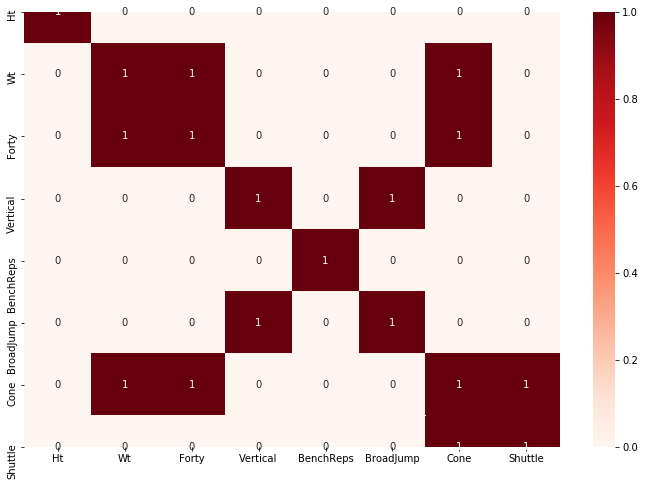

In [19]:
plt.figure(figsize=(12,8))
cor = combine_atg_num.corr()>=0.8
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [20]:
combine_atg['time_per_pound'] = combine_atg.Forty/combine_atg.Wt

In [21]:
combine_atg.drop('Wt',axis=1,inplace=True)
combine_atg.drop('Cone',axis=1,inplace=True)
combine_atg.drop('BroadJump',axis=1,inplace=True)

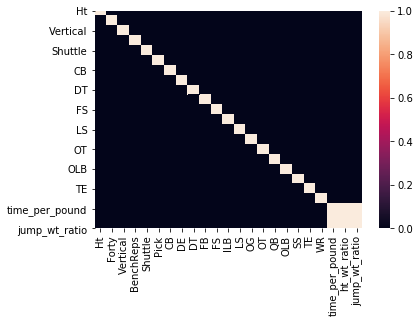

In [22]:
sns.heatmap(abs(combine_atg.corr()>=.8))

## Train - Test - Split

In [24]:
df_features = combine_atg.drop('Pick',axis=1)

In [25]:
df_target = combine_atg[['Pick']]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_features,df_target,test_size=0.3,random_state=45)

In [27]:
print(X_train.shape[0]==y_train.shape[0])
print(X_test.shape[0]==y_test.shape[0])

True
True


## Check messy model

#### Using intercept

In [28]:
lr = LinearRegression()
lr.fit(df_features, df_target)
y_hat_f = lr.predict(df_features)
print(f"r^2: {r2_score(df_target, y_hat_f)}")
print(f"rmse: {np.sqrt(mean_squared_error(df_target, y_hat_f))}")

r^2: 0.11993681269819301
rmse: 65.12874124037053


#### Not using intercept

In [29]:
feat_mod=sm.OLS(df_target,df_features)
feat_results=feat_mod.fit()
feat_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Pick   R-squared (uncentered):                   0.770
Model:                            OLS   Adj. R-squared (uncentered):              0.767
Method:                 Least Squares   F-statistic:                              287.6
Date:                Fri, 21 Feb 2020   Prob (F-statistic):                        0.00
Time:                        14:57:55   Log-Likelihood:                         -9724.9
No. Observations:                1737   AIC:                                  1.949e+04
Df Residuals:                    1717   BIC:                                  1.960e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Ht             -5.7962      0.883     -6.565      0.000      -7.528      -4.064
Forty         104.1515     11.161      9.332      0.000      82.261     126.042
Vertical       -2.2065      0.572     -3.856      0.000      -3.329      -1.084
BenchReps      -1.2634      0.357     -3.541      0.000      -1.963      -0.564
Shuttle        -3.5410     10.254     -0.345      0.730     -23.653      16.571
CB            -35.0084      8.684     -4.032      0.000     -52.040     -17.977
DE             18.3889      7.600      2.420      0.016       3.483      33.295
DT             -2.4548      8.828     -0.278      0.781     -19.769      14.859
FB             49.7605     11.073      4.494      0.000      28.042      71.479
FS             -8.7738      9.664     -0.908      0.364     -27.728      10.180
ILB            12.7527      8.826      1.445      0.149      -4.558      30.063
LS             35.7020     66.016      0.541      0.589     -93.778     165.182
OG             -4.5025      9.750     -0.462      0.644     -23.625      14.620
OT             -8.6620      9.171     -0.944      0.345     -26.650       9.326
QB              0.4963     46.805      0.011      0.992     -91.305      92.297
OLB            10.0915      7.158      1.410      0.159      -3.948      24.131
SS             12.0178     10.178      1.181      0.238      -7.945      31.981
TE             24.8823      8.529      2.917      0.004       8.153      41.611
WR             -1.8976      8.913     -0.213      0.831     -19.379      15.584
ht_wt_ratio   545.0337     89.760      6.072      0.000     368.983     721.085
==============================================================================
Omnibus:                      172.613   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.517
Skew:                           0.310   Prob(JB):                     6.59e-17
Kurtosis:                       2.197   Cond. No.                     4.84e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Train data

In [30]:
print(X_train.shape)
X_train.head()

(1215, 20)


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR,ht_wt_ratio
Player,,,,,,,,,,,,,,,,,,,,
Lance Kendricks,75,4.65,34.5,25.0,4.15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.308642
Jonathan Allen,75,5.00,30.0,21.0,4.50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.262238
Kraig Urbik,77,5.25,24.0,29.0,4.89,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.234756
Levine Toilolo,80,4.86,31.0,17.0,4.57,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.307692
Tony Scheffler,77,4.54,33.5,17.0,4.01,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.303150


In [31]:
print('not normal: Wt, Ht, Forty, Cone')

not normal: Wt, Ht, Forty, Cone


#### Standard scale

In [32]:
ss = MinMaxScaler()
ss.fit_transform(X_train[['Ht']]).flatten()
X_train['Ht'] = ss.fit_transform(X_train[['Ht']]).flatten()
ss.fit_transform(X_train[['Forty']]).flatten()
X_train['Forty'] = ss.fit_transform(X_train[['Forty']]).flatten()
ss.fit_transform(X_train[['Vertical']]).flatten()
X_train['Vertical'] = ss.fit_transform(X_train[['Vertical']]).flatten()
ss.fit_transform(X_train[['BenchReps']]).flatten()
X_train['BenchReps'] = ss.fit_transform(X_train[['BenchReps']]).flatten()

In [33]:
print(X_train.shape)
X_train.head()

(1215, 20)


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR,ht_wt_ratio
Player,,,,,,,,,,,,,,,,,,,,
Lance Kendricks,0.583333,0.289062,0.575,0.612903,4.15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.308642
Jonathan Allen,0.583333,0.562500,0.350,0.483871,4.50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.262238
Kraig Urbik,0.750000,0.757813,0.050,0.741935,4.89,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.234756
Levine Toilolo,1.000000,0.453125,0.400,0.354839,4.57,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.307692
Tony Scheffler,0.750000,0.203125,0.525,0.354839,4.01,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.303150


### Score

#### Using Ridge regularization

In [34]:
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train,y_train)
ridge_coef_tr = pd.DataFrame(ridge_reg.coef_)
ridge_coef_tr.columns=X_train.columns
print(ridge_reg.score(X_train,y_train))
ridge_coef_tr

0.13357354551866374


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR,ht_wt_ratio
0,-59.113276,157.52381,-35.512723,-40.320618,3.891081,-40.389584,11.253571,-4.84199,50.72349,-20.408785,8.318653,24.263622,-15.083028,-16.522399,-10.062111,-0.125855,17.527579,12.575089,-5.857464,655.159708


#### Using intercept

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat_tr = lr.predict(X_train)
coef_df = pd.DataFrame(lr.coef_)
coef_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-55.787159,169.789366,-36.446512,-34.217679,6.226851,-47.42173,12.645335,0.022919,51.088625,-25.954919,8.093659,19.928754,-11.811138,-13.756818,-16.223789,-0.273779,13.075317,12.233055,-11.849238,839.685844


In [36]:
print(f"r^2: {r2_score(y_train, y_hat_tr)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_train, y_hat_tr))}")

r^2: 0.1345774795367295
rmse: 65.96074895045695


In [37]:
X_int_train = sm.add_constant(X_train)
mod = sm.OLS(y_train,X_int_train).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Pick   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     9.284
Date:                Fri, 21 Feb 2020   Prob (F-statistic):           1.54e-26
Time:                        14:57:56   Log-Likelihood:                -6813.7
No. Observations:                1215   AIC:                         1.367e+04
Df Residuals:                    1194   BIC:                         1.378e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -157.7180     86.664     -1.820      0.069    -327.749      12.313
Ht            -55.7872     15.292     -3.648      0.000     -85.790     -25.784
Forty         169.7894     20.954      8.103      0.000     128.678     210.901
Vertical      -36.4465     14.916     -2.443      0.015     -65.711      -7.182
BenchReps     -34.2177     13.904     -2.461      0.014     -61.496      -6.939
Shuttle         6.2269     13.462      0.463      0.644     -20.185      32.639
CB            -47.4217     10.879     -4.359      0.000     -68.765     -26.078
DE             12.6453      9.347      1.353      0.176      -5.692      30.983
DT              0.0229     10.576      0.002      0.998     -20.726      20.772
FB             51.0886     13.648      3.743      0.000      24.313      77.864
FS            -25.9549     11.901     -2.181      0.029     -49.304      -2.606
ILB             8.0937     10.724      0.755      0.451     -12.947      29.134
LS             19.9288     67.045      0.297      0.766    -111.609     151.467
OG            -11.8111     11.933     -0.990      0.322     -35.224      11.602
OT            -13.7568     11.268     -1.221      0.222     -35.864       8.351
QB            -16.2238     47.742     -0.340      0.734    -109.891      77.444
OLB            -0.2738      8.644     -0.032      0.975     -17.233      16.686
SS             13.0753     12.290      1.064      0.288     -11.036      37.187
TE             12.2331     10.764      1.137      0.256      -8.885      33.351
WR            -11.8492     11.232     -1.055      0.292     -33.887      10.188
ht_wt_ratio   839.6858    156.888      5.352      0.000     531.879    1147.492
==============================================================================
Omnibus:                      111.512   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.532
Skew:                           0.267   Prob(JB):                     7.86e-11
Kurtosis:                       2.204   Cond. No.                         414.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Not using intercept

In [38]:
mod = sm.OLS(y_train,X_train).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Pick   R-squared (uncentered):                   0.772
Model:                            OLS   Adj. R-squared (uncentered):              0.768
Method:                 Least Squares   F-statistic:                              201.9
Date:                Fri, 21 Feb 2020   Prob (F-statistic):                        0.00
Time:                        14:57:56   Log-Likelihood:                         -6815.4
No. Observations:                1215   AIC:                                  1.367e+04
Df Residuals:                    1195   BIC:                                  1.377e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Ht            -58.6460     15.226     -3.852      0.000     -88.519     -28.773
Forty         158.6783     20.064      7.908      0.000     119.313     198.044
Vertical      -42.5055     14.554     -2.921      0.004     -71.059     -13.952
BenchReps     -42.2184     13.203     -3.198      0.001     -68.123     -16.314
Shuttle       -12.5445      8.659     -1.449      0.148     -29.534       4.445
CB            -42.3031     10.519     -4.022      0.000     -62.941     -21.665
DE             11.1430      9.319      1.196      0.232      -7.141      29.427
DT             -4.1607     10.333     -0.403      0.687     -24.433      16.112
FB             49.6722     13.638      3.642      0.000      22.914      76.430
FS            -21.7829     11.689     -1.864      0.063     -44.716       1.151
ILB             6.1833     10.683      0.579      0.563     -14.776      27.143
LS             23.0574     67.087      0.344      0.731    -108.565     154.679
OG            -13.8600     11.892     -1.166      0.244     -37.191       9.471
OT            -14.8855     11.262     -1.322      0.187     -36.981       7.210
QB            -10.3664     47.679     -0.217      0.828    -103.911      83.178
OLB            -1.5784      8.623     -0.183      0.855     -18.496      15.339
SS             15.8864     12.204      1.302      0.193      -8.057      39.830
TE             11.4213     10.765      1.061      0.289      -9.699      32.541
WR             -6.4015     10.837     -0.591      0.555     -27.663      14.860
ht_wt_ratio   631.1429    107.260      5.884      0.000     420.704     841.582
==============================================================================
Omnibus:                      125.721   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.562
Skew:                           0.264   Prob(JB):                     2.85e-11
Kurtosis:                       2.175   Cond. No.                         256.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Repeat on test data

In [39]:
print(X_test.shape)
X_test.head()

(522, 20)


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR,ht_wt_ratio
Player,,,,,,,,,,,,,,,,,,,,
Rakeem Nunez-Roches,74,5.02,34.0,26.0,4.69,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.241042
Will Davis-02,71,4.51,35.5,16.0,4.02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.381720
Daryn Colledge,76,5.05,32.5,21.0,4.58,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.254181
Bashaud Breeland,71,4.62,34.5,11.0,4.33,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.360406
Al-Quadin Muhammad,75,4.88,30.5,22.0,4.47,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.296443


#### Box-Cox: normalize

In [40]:
X_test['Forty']=list(stats.boxcox(abs(X_test['Forty'])))[0]
X_test['Ht']=list(stats.boxcox(abs(X_test['Ht'])))[0]

#### Standard scale

In [41]:
ss = StandardScaler()
ss.fit_transform(X_test[['Ht']]).flatten()
X_test['Ht'] = ss.fit_transform(X_test[['Ht']]).flatten()
ss.fit_transform(X_test[['Forty']]).flatten()
X_test['Forty'] = ss.fit_transform(X_test[['Forty']]).flatten()
ss.fit_transform(X_test[['Vertical']]).flatten()
X_test['Vertical'] = ss.fit_transform(X_test[['Vertical']]).flatten()
ss.fit_transform(X_test[['BenchReps']]).flatten()
X_test['BenchReps'] = ss.fit_transform(X_test[['BenchReps']]).flatten()

In [42]:
print(X_test.shape)
X_test.head()

(522, 20)


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR,ht_wt_ratio
Player,,,,,,,,,,,,,,,,,,,,
Rakeem Nunez-Roches,-0.052873,0.991874,0.205579,0.801941,4.69,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.241042
Will Davis-02,-1.162439,-0.863337,0.601077,-0.848092,4.02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.381720
Daryn Colledge,0.777277,1.070283,-0.189920,-0.023075,4.58,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.254181
Bashaud Breeland,-1.162439,-0.361708,0.337411,-1.673108,4.33,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.360406
Al-Quadin Muhammad,0.352761,0.588387,-0.717252,0.141928,4.47,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.296443


### Score

#### Using Ridge regularization

In [43]:
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train,y_train)
ridge_coef_tr = pd.DataFrame(ridge_reg.coef_)
ridge_coef_tr.columns=X_train.columns
print(ridge_reg.score(X_test,y_test))
ridge_coef_tr

-2.9426675760510004


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR,ht_wt_ratio
0,-59.113276,157.52381,-35.512723,-40.320618,3.891081,-40.389584,11.253571,-4.84199,50.72349,-20.408785,8.318653,24.263622,-15.083028,-16.522399,-10.062111,-0.125855,17.527579,12.575089,-5.857464,655.159708


#### Using intercept

In [44]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat_te = lr.predict(X_test)
coef_df = pd.DataFrame(lr.coef_)
coef_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-55.787159,169.789366,-36.446512,-34.217679,6.226851,-47.42173,12.645335,0.022919,51.088625,-25.954919,8.093659,19.928754,-11.811138,-13.756818,-16.223789,-0.273779,13.075317,12.233055,-11.849238,839.685844


In [45]:
print(f"r^2: {r2_score(y_test, y_hat_te)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_test, y_hat_te))}")

r^2: -3.4939558997241864
rmse: 139.37166295910515


#### Not using intercept

In [46]:
mod = sm.OLS(y_test,X_test).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Pick   R-squared (uncentered):                   0.781
Model:                            OLS   Adj. R-squared (uncentered):              0.773
Method:                 Least Squares   F-statistic:                              99.93
Date:                Fri, 21 Feb 2020   Prob (F-statistic):                   3.47e-153
Time:                        14:57:56   Log-Likelihood:                         -2891.8
No. Observations:                 522   AIC:                                      5820.
Df Residuals:                     504   BIC:                                      5896.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Ht             -8.5949      4.713     -1.824      0.069     -17.854       0.664
Forty          35.5859      6.698      5.313      0.000      22.426      48.746
Vertical       -2.4213      3.971     -0.610      0.542     -10.223       5.381
BenchReps      -5.1669      3.897     -1.326      0.185     -12.823       2.489
Shuttle       -14.9648     11.053     -1.354      0.176     -36.680       6.751
CB            -19.3129     14.875     -1.298      0.195     -48.538       9.913
DE             13.0782     13.072      1.000      0.318     -12.605      38.761
DT            -10.6224     15.807     -0.672      0.502     -41.677      20.433
FB             44.6528     18.702      2.388      0.017       7.908      81.397
FS              7.4274     17.829      0.417      0.677     -27.600      42.455
ILB            13.0473     15.282      0.854      0.394     -16.977      43.072
LS           6.775e-14   1.84e-14      3.691      0.000    3.17e-14    1.04e-13
OG              2.4211     16.831      0.144      0.886     -30.647      35.489
OT            -15.3558     16.626     -0.924      0.356     -48.021      17.309
QB           6.656e-14   9.33e-14      0.713      0.476   -1.17e-13     2.5e-13
OLB            24.1799     12.553      1.926      0.055      -0.482      48.842
SS            -10.9933     18.776     -0.585      0.558     -47.882      25.896
TE             28.2682     14.583      1.938      0.053      -0.383      56.920
WR              7.3758     15.654      0.471      0.638     -23.379      38.131
ht_wt_ratio   577.0189    160.731      3.590      0.000     261.234     892.804
==============================================================================
Omnibus:                       29.922   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.373
Skew:                           0.385   Prob(JB):                     2.29e-05
Kurtosis:                       2.377   Cond. No.                     5.98e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.82e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""